<a href="https://colab.research.google.com/github/vggd18/mlp-cnn-cifar10/blob/main/CIFAR10_with_MLPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 with MLPs
Simple starter notebook to benchmark your own MLP with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

In [ ]:
#@title 1️ Libraries
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import pandas as pd


In [ ]:
#@title 2️ Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


In [ ]:
#@title 3 Defining the MLP model with Dropout
class MLP(nn.Module):
  def __init__(self, input_size, num_classes, activation_function):
    super(MLP, self).__init__()
    self.activation_function = activation_function

    self.fc_input = nn.Linear(input_size, 64)
    self.dropout1 = nn.Dropout(p=0.3)

    self.fc_hidden1 = nn.Linear(64, 128)
    self.dropout2 = nn.Dropout(p=0.3)

    self.fc_hidden2 = nn.Linear(128, 64)
    self.fc_output = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.activation_function(self.fc_input(x))
    x = self.dropout1(x)

    x = self.activation_function(self.fc_hidden1(x))
    x = self.dropout2(x)

    x = self.activation_function(self.fc_hidden2(x))
    x = self.fc_output(x)
    return x


In [ ]:
#@title 4️ Metrics Helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

def class_wise_accuracy(model, dataloader, device):
    model.eval()
    n_classes = 10
    correct = [0]*n_classes
    total = [0]*n_classes
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.view(-1, 32*32*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i] == labels[i]:
                    correct[labels[i]] += 1
    return [100*c/t if t>0 else 0 for c,t in zip(correct,total)]


In [ ]:
#@title 5️ Optimized Hyperparameters

input_size = 32*32*3
num_classes = 10

learning_rate = 0.0005
num_epochs = 100
batch_size = 128
activation_function = nn.ReLU()
loss_function = nn.CrossEntropyLoss()


In [ ]:
#@title 6️ Data Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
#@title 7 Training loop

# Build the model
mlp = MLP(input_size=input_size, num_classes=num_classes, activation_function=activation_function)
mlp.cuda()

# ⚙️ Definir o otimizador Adam com regularização L2
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=1e-4)

# 📉 Definir o scheduler (reduz o learning rate se a loss parar de cair)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,32*32*3).cuda()
    labels = labels.cuda()

    # Forward + backward
    optimizer.zero_grad()
    outputs = mlp(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')

  # 🔁 Atualizar o scheduler com a loss média da época
  scheduler.step(epoch_loss)

  # Early stopping
  if epoch_loss < best_loss:
    best_loss = epoch_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break


  1%|          | 1/100 [00:11<19:32, 11.84s/it]

Epoch 1 average loss: 1.8820


  2%|▏         | 2/100 [00:23<19:12, 11.76s/it]

Epoch 2 average loss: 1.7073


  3%|▎         | 3/100 [00:35<19:08, 11.84s/it]

Epoch 3 average loss: 1.6485


  4%|▍         | 4/100 [00:47<18:52, 11.80s/it]

Epoch 4 average loss: 1.6076


  5%|▌         | 5/100 [00:59<18:44, 11.84s/it]

Epoch 5 average loss: 1.5759


  6%|▌         | 6/100 [01:10<18:32, 11.83s/it]

Epoch 6 average loss: 1.5535


  7%|▋         | 7/100 [01:22<18:15, 11.78s/it]

Epoch 7 average loss: 1.5253


  8%|▊         | 8/100 [01:34<18:05, 11.80s/it]

Epoch 8 average loss: 1.5084


  9%|▉         | 9/100 [01:46<17:54, 11.81s/it]

Epoch 9 average loss: 1.4916


 10%|█         | 10/100 [01:57<17:37, 11.75s/it]

Epoch 10 average loss: 1.4739


 11%|█         | 11/100 [02:09<17:29, 11.79s/it]

Epoch 11 average loss: 1.4649


 12%|█▏        | 12/100 [02:21<17:18, 11.80s/it]

Epoch 12 average loss: 1.4530


 13%|█▎        | 13/100 [02:33<17:04, 11.78s/it]

Epoch 13 average loss: 1.4399


 14%|█▍        | 14/100 [02:44<16:49, 11.74s/it]

Epoch 14 average loss: 1.4286


 15%|█▌        | 15/100 [02:56<16:31, 11.66s/it]

Epoch 15 average loss: 1.4244


 16%|█▌        | 16/100 [03:07<16:16, 11.62s/it]

Epoch 16 average loss: 1.4096


 17%|█▋        | 17/100 [03:19<15:55, 11.51s/it]

Epoch 17 average loss: 1.4087


 18%|█▊        | 18/100 [03:30<15:39, 11.45s/it]

Epoch 18 average loss: 1.3978


 19%|█▉        | 19/100 [03:42<15:31, 11.50s/it]

Epoch 19 average loss: 1.3918


 20%|██        | 20/100 [03:53<15:25, 11.57s/it]

Epoch 20 average loss: 1.3801


 21%|██        | 21/100 [04:05<15:20, 11.65s/it]

Epoch 21 average loss: 1.3779


 22%|██▏       | 22/100 [04:17<15:11, 11.69s/it]

Epoch 22 average loss: 1.3705


 23%|██▎       | 23/100 [04:29<14:58, 11.67s/it]

Epoch 23 average loss: 1.3605


 24%|██▍       | 24/100 [04:40<14:44, 11.64s/it]

Epoch 24 average loss: 1.3631


 25%|██▌       | 25/100 [04:52<14:28, 11.58s/it]

Epoch 25 average loss: 1.3527


 26%|██▌       | 26/100 [05:03<14:17, 11.59s/it]

Epoch 26 average loss: 1.3410


 27%|██▋       | 27/100 [05:15<14:05, 11.58s/it]

Epoch 27 average loss: 1.3466


 28%|██▊       | 28/100 [05:27<14:00, 11.68s/it]

Epoch 28 average loss: 1.3379


 29%|██▉       | 29/100 [05:38<13:48, 11.67s/it]

Epoch 29 average loss: 1.3354


 30%|███       | 30/100 [05:50<13:33, 11.62s/it]

Epoch 30 average loss: 1.3301


 31%|███       | 31/100 [06:01<13:20, 11.60s/it]

Epoch 31 average loss: 1.3297


 32%|███▏      | 32/100 [06:13<13:05, 11.55s/it]

Epoch 32 average loss: 1.3207


 33%|███▎      | 33/100 [06:25<12:56, 11.59s/it]

Epoch 33 average loss: 1.3160


 34%|███▍      | 34/100 [06:36<12:49, 11.65s/it]

Epoch 34 average loss: 1.3174


 35%|███▌      | 35/100 [06:48<12:42, 11.74s/it]

Epoch 35 average loss: 1.3048


 36%|███▌      | 36/100 [07:00<12:34, 11.79s/it]

Epoch 36 average loss: 1.3068


 37%|███▋      | 37/100 [07:12<12:21, 11.76s/it]

Epoch 37 average loss: 1.3056


 38%|███▊      | 38/100 [07:24<12:09, 11.76s/it]

Epoch 38 average loss: 1.3066


 39%|███▉      | 39/100 [07:35<11:58, 11.78s/it]

Epoch 39 average loss: 1.2964


 40%|████      | 40/100 [07:47<11:45, 11.77s/it]

Epoch 40 average loss: 1.2955


 41%|████      | 41/100 [07:58<11:24, 11.60s/it]

Epoch 41 average loss: 1.2904


 42%|████▏     | 42/100 [08:10<11:11, 11.57s/it]

Epoch 42 average loss: 1.2879


 43%|████▎     | 43/100 [08:21<10:57, 11.53s/it]

Epoch 43 average loss: 1.2854


 44%|████▍     | 44/100 [08:33<10:51, 11.64s/it]

Epoch 44 average loss: 1.2808


 45%|████▌     | 45/100 [08:45<10:39, 11.63s/it]

Epoch 45 average loss: 1.2809


 46%|████▌     | 46/100 [08:57<10:30, 11.67s/it]

Epoch 46 average loss: 1.2734


 47%|████▋     | 47/100 [09:08<10:19, 11.70s/it]

Epoch 47 average loss: 1.2765


 48%|████▊     | 48/100 [09:20<10:04, 11.62s/it]

Epoch 48 average loss: 1.2689


 49%|████▉     | 49/100 [09:32<09:56, 11.69s/it]

Epoch 49 average loss: 1.2640


 50%|█████     | 50/100 [09:43<09:42, 11.66s/it]

Epoch 50 average loss: 1.2662


 51%|█████     | 51/100 [09:55<09:29, 11.62s/it]

Epoch 51 average loss: 1.2620


 52%|█████▏    | 52/100 [10:06<09:17, 11.62s/it]

Epoch 52 average loss: 1.2625


 53%|█████▎    | 53/100 [10:18<09:06, 11.64s/it]

Epoch 53 average loss: 1.2598


 54%|█████▍    | 54/100 [10:30<09:00, 11.75s/it]

Epoch 54 average loss: 1.2527


 55%|█████▌    | 55/100 [10:42<08:46, 11.70s/it]

Epoch 55 average loss: 1.2528


 56%|█████▌    | 56/100 [10:53<08:34, 11.69s/it]

Epoch 56 average loss: 1.2503


 57%|█████▋    | 57/100 [11:05<08:24, 11.74s/it]

Epoch 57 average loss: 1.2551


 58%|█████▊    | 58/100 [11:17<08:10, 11.68s/it]

Epoch 58 average loss: 1.2475


 59%|█████▉    | 59/100 [11:29<08:00, 11.72s/it]

Epoch 59 average loss: 1.2449


 60%|██████    | 60/100 [11:40<07:49, 11.74s/it]

Epoch 60 average loss: 1.2424


 61%|██████    | 61/100 [11:52<07:37, 11.73s/it]

Epoch 61 average loss: 1.2431


 62%|██████▏   | 62/100 [12:04<07:27, 11.77s/it]

Epoch 62 average loss: 1.2384


 63%|██████▎   | 63/100 [12:16<07:13, 11.71s/it]

Epoch 63 average loss: 1.2391


 64%|██████▍   | 64/100 [12:27<07:02, 11.75s/it]

Epoch 64 average loss: 1.2360


 65%|██████▌   | 65/100 [12:39<06:51, 11.77s/it]

Epoch 65 average loss: 1.2347


 66%|██████▌   | 66/100 [12:51<06:37, 11.70s/it]

Epoch 66 average loss: 1.2361


 67%|██████▋   | 67/100 [13:02<06:22, 11.58s/it]

Epoch 67 average loss: 1.2294


 68%|██████▊   | 68/100 [13:14<06:14, 11.69s/it]

Epoch 68 average loss: 1.2273


 69%|██████▉   | 69/100 [13:26<06:03, 11.73s/it]

Epoch 69 average loss: 1.2284


 70%|███████   | 70/100 [13:38<05:53, 11.80s/it]

Epoch 70 average loss: 1.2266


 71%|███████   | 71/100 [13:49<05:41, 11.77s/it]

Epoch 71 average loss: 1.2240


 72%|███████▏  | 72/100 [14:01<05:29, 11.75s/it]

Epoch 72 average loss: 1.2231


 73%|███████▎  | 73/100 [14:13<05:18, 11.80s/it]

Epoch 73 average loss: 1.2208


 74%|███████▍  | 74/100 [14:25<05:06, 11.80s/it]

Epoch 74 average loss: 1.2124


 75%|███████▌  | 75/100 [14:37<04:55, 11.84s/it]

Epoch 75 average loss: 1.2158


 76%|███████▌  | 76/100 [14:48<04:42, 11.77s/it]

Epoch 76 average loss: 1.2157


 77%|███████▋  | 77/100 [15:00<04:28, 11.69s/it]

Epoch 77 average loss: 1.2132


 78%|███████▊  | 78/100 [15:12<04:16, 11.67s/it]

Epoch 78 average loss: 1.2148


 79%|███████▉  | 79/100 [15:23<04:05, 11.70s/it]

Epoch 79 average loss: 1.2098


 80%|████████  | 80/100 [15:35<03:54, 11.75s/it]

Epoch 80 average loss: 1.2043


 81%|████████  | 81/100 [15:47<03:42, 11.69s/it]

Epoch 81 average loss: 1.2083


 82%|████████▏ | 82/100 [15:58<03:30, 11.69s/it]

Epoch 82 average loss: 1.2118


 83%|████████▎ | 83/100 [16:10<03:18, 11.71s/it]

Epoch 83 average loss: 1.2057


 84%|████████▍ | 84/100 [16:22<03:07, 11.69s/it]

Epoch 84 average loss: 1.2057


 85%|████████▌ | 85/100 [16:34<02:56, 11.74s/it]

Epoch 85 average loss: 1.2006


 86%|████████▌ | 86/100 [16:45<02:43, 11.69s/it]

Epoch 86 average loss: 1.2033


 87%|████████▋ | 87/100 [16:57<02:32, 11.71s/it]

Epoch 87 average loss: 1.1952


 88%|████████▊ | 88/100 [17:09<02:20, 11.75s/it]

Epoch 88 average loss: 1.1967


 89%|████████▉ | 89/100 [17:21<02:09, 11.74s/it]

Epoch 89 average loss: 1.1935


 90%|█████████ | 90/100 [17:32<01:57, 11.72s/it]

Epoch 90 average loss: 1.1912


 91%|█████████ | 91/100 [17:44<01:45, 11.73s/it]

Epoch 91 average loss: 1.1924


 92%|█████████▏| 92/100 [17:56<01:33, 11.67s/it]

Epoch 92 average loss: 1.1910


 93%|█████████▎| 93/100 [18:08<01:22, 11.77s/it]

Epoch 93 average loss: 1.1884


 94%|█████████▍| 94/100 [18:19<01:10, 11.82s/it]

Epoch 94 average loss: 1.1926


 95%|█████████▌| 95/100 [18:31<00:59, 11.82s/it]

Epoch 95 average loss: 1.1836


 96%|█████████▌| 96/100 [18:43<00:47, 11.90s/it]

Epoch 96 average loss: 1.1888


 97%|█████████▋| 97/100 [18:55<00:35, 11.84s/it]

Epoch 97 average loss: 1.1916


 98%|█████████▊| 98/100 [19:07<00:23, 11.74s/it]

Epoch 98 average loss: 1.1839


 99%|█████████▉| 99/100 [19:18<00:11, 11.70s/it]

Epoch 99 average loss: 1.1778


100%|██████████| 100/100 [19:30<00:00, 11.70s/it]

Epoch 100 average loss: 1.1869


In [ ]:
#@title 8️ Evaluate Model (Overall & Class-wise Accuracy)
# Detectar se há GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Mover o modelo para o device
mlp.to(device)
mlp.eval()
predictions = []
labels_all = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1,32*32*3).to(device)
        labels = labels.to(device)
        outputs = mlp(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

scores = get_scores(labels_all, predictions)
per_class_acc = class_wise_accuracy(mlp, test_loader, device)

print("Overall Scores:", scores)
print("Class-wise Accuracy:", per_class_acc)


Usando dispositivo: cuda
Overall Scores: {'accuracy': 0.527, 'balanced_accuracy': np.float64(0.5269999999999999), 'precision': 0.5304244048023082, 'recall': 0.527, 'f1_score': 0.5262117979426535}
Class-wise Accuracy: [61.2, 61.2, 35.2, 38.8, 54.3, 39.0, 54.4, 53.6, 67.7, 61.6]


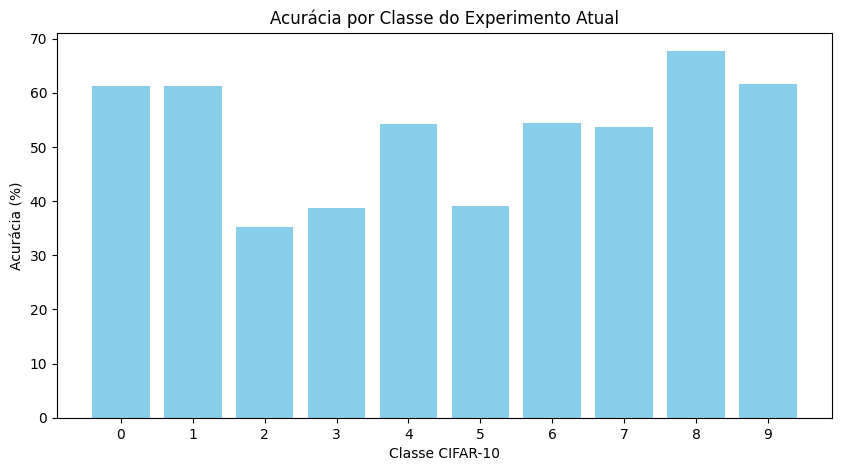

Acurácia global média por classe: 52.70%


In [ ]:
#@title 9 Plot Experiments Comparison
def class_wise_accuracy(model, dataloader, device):
    model.eval()
    n_classes = 10
    correct = [0]*n_classes
    total = [0]*n_classes
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.view(-1, 32*32*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i] == labels[i]:
                    correct[labels[i]] += 1
    return [100*c/t if t>0 else 0 for c,t in zip(correct,total)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

per_class_acc = class_wise_accuracy(mlp, test_loader, device)

# Gráfico de acurácia por classe
plt.figure(figsize=(10,5))
plt.bar(range(10), per_class_acc, color='skyblue')
plt.xlabel('Classe CIFAR-10')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia por Classe do Experimento Atual')
plt.xticks(range(10))
plt.show()

# Acurácia global
accuracy_global = np.mean(per_class_acc)
print(f"Acurácia global média por classe: {accuracy_global:.2f}%")


# You can change/optimize this as you want
- Different optimizers, activation functions, etc
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques
- Validation set to track metrics during epochs
- Transform input data
- ...